In [2]:
!nvidia-smi

Wed Apr 14 04:06:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os, requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50 
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
IMAGE_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [6]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_dir = os.path.join(working_dir, "landmarks/local")
model_root_dir = os.path.join(working_dir, "models/haochen")

In [7]:
print('number of local labels:', len(os.listdir(data_dir)))

number of local labels: 11


In [8]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 3650 images belonging to 11 classes.
Found 909 images belonging to 11 classes.


In [9]:
load_model_dir = os.path.join(model_root_dir, "restnet50_classification_v1_international_bucket_21")
model = tf.keras.models.load_model(load_model_dir)

In [10]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
last_layer = model.get_layer("predictions")
last_output = last_layer.output

In [12]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation=layers.LeakyReLU(alpha=0.01))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation=layers.LeakyReLU(alpha=0.01))(x)
x = layers.BatchNormalization(momentum=0.95, name="batch_norm_pre-output")(x)
x = layers.Dense(11, activation='softmax')(x)

model = Model(model.input, x)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 57
Validation steps: 14


In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

save_model_dir = os.path.join(model_root_dir, "restnet50_classification_v1_landmark_1")
model.save(save_model_dir)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 1.9455 - accuracy: 0.3432

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


57/57 [==============================] - 267s 5s/step - loss: 1.9415 - accuracy: 0.3447 - val_loss: 2.1059 - val_accuracy: 0.3728
Epoch 2/30
57/57 [==============================] - 94s 2s/step - loss: 1.2233 - accuracy: 0.6111 - val_loss: 1.5967 - val_accuracy: 0.4754
Epoch 3/30
57/57 [==============================] - 94s 2s/step - loss: 0.9734 - accuracy: 0.7004 - val_loss: 1.4701 - val_accuracy: 0.5469
Epoch 4/30
57/57 [==============================] - 94s 2s/step - loss: 0.7938 - accuracy: 0.7535 - val_loss: 1.6405 - val_accuracy: 0.5379
Epoch 5/30
57/57 [==============================] - 94s 2s/step - loss: 0.7322 - accuracy: 0.7595 - val_loss: 1.9978 - val_accuracy: 0.5011
Epoch 6/30
57/57 [==============================] - 94s 2s/step - loss: 0.6367 - accuracy: 0.7955 - val_loss: 1.4877 - val_accuracy: 0.5926
Epoch 7/30
57/57 [==============================] - 94s 2s/step - loss: 0.5092 - accuracy: 0.8493 - val_loss: 1.6663 - val_accuracy: 0.5658
Epoch 8/30
57/57 [============

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/haochen/restnet50_classification_v1_landmark_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/haochen/restnet50_classification_v1_landmark_1/assets


Text(0.5, 1.0, 'Training and validation loss')

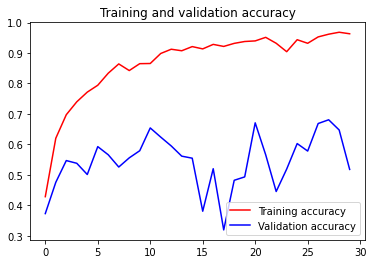

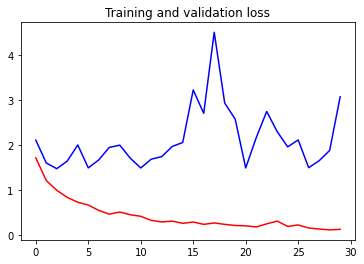

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

In [20]:
url = "https://www.buro247.sg/thumb/950x700/local/images/buro/galleries/2019/11/4_untitled-1.jpg"

try:
  image_data = requests.get(url, stream=True).raw
except Exception as e:
  print('Warning: Could not download image from %s' % url)
  print('Error: %s' %e)
  raise

try:
  pil_image = Image.open(image_data)
except Exception as e:
  print('Warning: Failed to parse image')
  print('Error: %s' %e)
  raise

try:
  img = pil_image.convert('RGB').resize(IMAGE_SIZE)
except:
  print('Warning: Failed to format image')
  raise

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

classes = model.predict(x)
labels = list(train_generator.class_indices.keys())

for i in range(len(classes[0])):
  print("%s: %s" % (labels[i], classes[0][i]))

bugis: 2.1361866e-09
chinatown: 2.1445487e-06
clarke quay: 2.4364315e-06
esplanade: 7.67399e-07
flowerdome: 1.4452357e-07
flyer: 0.9358268
hajilane: 3.378715e-09
marinabaysands: 8.479508e-08
merlion: 0.064050056
supertree: 0.00010493423
uss: 1.2652566e-05


In [18]:
a = [("bugis", 0.00035603173),
("chinatown", 0.0032460527),
("clarke quay", 0.002140329),
("esplanade", 0.0017281657),
("flowerdome", 0.015826598),
("flyer", 0.030071266),
("hajilane", 0.0028528182),
("marinabaysands", 0.0071350085),
("merlion", 0.0117828),
("supertree", 0.9245005),
("uss", 0.0003604158)]

a.sort(key=lambda x:-x[1])

for i in range(0, len(a)):
  print("%s: %s" % (a[i][0], a[i][1]))

supertree: 0.9245005
flyer: 0.030071266
flowerdome: 0.015826598
merlion: 0.0117828
marinabaysands: 0.0071350085
chinatown: 0.0032460527
hajilane: 0.0028528182
clarke quay: 0.002140329
esplanade: 0.0017281657
uss: 0.0003604158
bugis: 0.00035603173
